In [6]:
import bempp.api 
import numpy as np
import mtf

from mtf.utils import bhmie
from mtf.config import config
from bempp.api.operators.boundary.sparse import identity
from mtf.operators.maxwell import assemble_mtf
from mtf.utils.iterative import gmres

from mtf.functions import define_bempp_functions
from bempp.api.assembly.blocked_operator import BlockedOperator
from mtf.assembly.operators import GeneralizedBlockedOperator

from matplotlib import pyplot as plt
bempp.api.enable_console_logging()
import argparse

parser = argparse.ArgumentParser(description="Set parameters")

parser.add_argument("--M", default=3, type=int)
parser.add_argument("--solver", default='gmres', type=str)
parser.add_argument("--precision", default=10, type=int)
parser.add_argument("--case", default="B", type=str)
args = parser.parse_args([])

M = args.M
solver = args.solver
case = args.case
precision = args.precision

M = 3
case = 'A'
precision = 10
solver = 'direct'

print('Solver is: ', solver)
config = mtf.config.set_case(case, True)
k0 = config['k_ext']
k1 = config['k_int']

numAngles = 901
s1, s2, qext, qsca, qback, gsca = bhmie(config['k_ext'], config['k_int'] / config['k_ext'], numAngles)
# to do: understand numAngles

if M == 2:
    #multiple shape, M=2
    segments = [[10, 20], [10, 20]]
    swapped_normals = [[10, 20], []]
elif M == 3:
    #multiple shape, M=3
    segments = [[10, 20], [10, 12], [12, 20]]
    swapped_normals = [[10, 20], [], [12]]


# Outside: k_ext
# Inside: k_int

k_list = [k0]
eta_rel_list = [1]
mu_list = [config['mu_ext']]


for index in range(M-1):
  k_list.append(k1)
  mu_list.append(config['mu_int'])
  eta_rel_list.append(config['eta_rel'])

print("k_ext: {:.2f}".format(config['k_ext']))
print("k_int: {:.2f}".format(config['k_int']))

print("----")
print("lambda: {:.2f}".format(config['lambda']))
print("f: {:.2E}".format(config['frequency']))

h = 2 * np.pi/(precision*k0)
grid = bempp.api.shapes.multitrace_sphere(h=h)

params = {}
params["M"] = M
params["k_list"] = k_list
params["mu_list"] = mu_list
params["eta_rel_list"] = eta_rel_list
params["segments"] = segments
params["swapped_normals"] = swapped_normals


if solver == 'gmres':
    lhs_prec, lhs_op, rhs = assemble_mtf(grid, params, config, solver=solver)
    P_wf = lhs_prec.weak_form()
else:
    lhs_op, rhs = assemble_mtf(grid, params, config, solver=solver)

# Solver
op_wf = lhs_op.weak_form()

b = bempp.api.assembly.blocked_operator.projections_from_grid_functions_list(
    rhs, lhs_op.dual_to_range_spaces
)
N = b.shape[0]

if solver == 'gmres':
    x, conv_gmres, res_gmres = gmres(P_wf * op_wf, P_wf * b, return_residuals=True, restart = 1000, maxiter=1000)
else:
    A = bempp.api.as_matrix(op_wf)
    x = np.linalg.solve(A, b)

sol = bempp.api.assembly.blocked_operator.grid_function_list_from_coefficients(
    x.ravel(), lhs_op.domain_spaces
)


far_field_points = config['far_field_points']
electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[1].space, far_field_points, k0)
magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[0].space, far_field_points, k0)    

far_field =  electric_far * sol[1] + magnetic_far * sol[0]

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k0) ))
rel_error = np.linalg.norm(uh - u) / np.linalg.norm(u)

if M == 3:
    interface = [12]
    interface_space = bempp.api.function_space(grid, "RWG", 0, segments=interface, include_boundary_dofs = True)

    map_dom0_to_interface = identity(sol[2].space, interface_space, interface_space)
    map_dom1_to_interface = identity(sol[4].space, interface_space, interface_space)
    
    trace0i = map_dom0_to_interface @ sol[2]
    trace1i = map_dom1_to_interface @ sol[4]
    
    normal_trace0i = map_dom0_to_interface @ sol[3]
    normal_trace1i = map_dom1_to_interface @ sol[5]
    
    dirichlet_jump = (trace0i + trace1i).l2_norm() / (trace0i.l2_norm())
    neumann_jump = (normal_trace0i + normal_trace1i).l2_norm() / (normal_trace0i.l2_norm())
    
    print(dirichlet_jump,': L^2 relative error for tangential traces')
    print(neumann_jump,': L^2 relative error for magnetic traces')

    interface_space_p1 = bempp.api.function_space(grid, "P", 1)

    c_p1 = np.linalg.norm(trace0i.evaluate_on_vertices(),axis=0)
    
    u_p1 = bempp.api.GridFunction(interface_space_p1, coefficients = c_p1)
elif M ==2: 
    dirichlet_jump = -1
    neumann_jump = -1
print(rel_error)

results = np.array([M, precision, h, N, dirichlet_jump, neumann_jump, rel_error])
name = 'results/' + str(M) + case + str(precision) + 'mtf' + solver

print(name)
np.save(name, results)


bempp:HOST:INFO: Created grid with id beb0f7c2-2ef9-4298-8b98-fd296f07dd7b. Elements: 1060. Edges: 1574. Vertices: 517


Solver is:  direct
k_ext: 3.00
k_int: 4.35
----
lambda: 2.09
f: 1.43E+08



bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


ValueError: operands could not be broadcast together with shapes (400,) (1801,) 

ValueError: x and y must have same first dimension, but have shapes (400,) and (1801,)

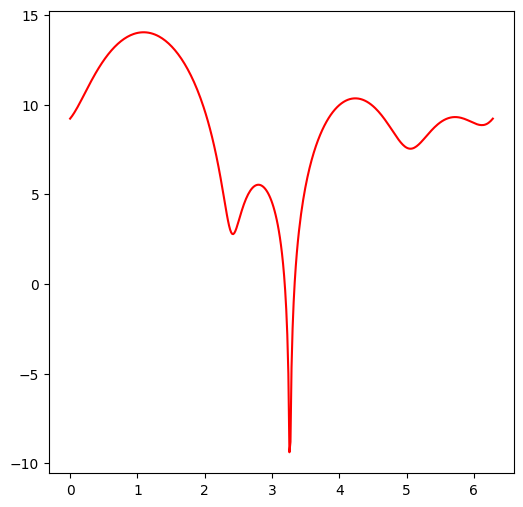

In [7]:
angles = config['angles']

fig, ax  = plt.subplots(1,1, figsize=(6,6))
plt.rcParams['figure.figsize'] = (15, 4) # Increase the figure size in the notebook

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k0) ))
# -1j * kExt is to make agree with eqn 3.21 p70 tBohren and Huffman

ax.plot(angles[:1801], uh, '-r', label='BEM')
ax.plot(angles[:1801], u, 'b', label='MIE', linestyle=(0, (5, 5)))

ax.set_xlabel(r"$\theta$ (rad)", fontsize=15)
ax.set_ylabel(r"$\mathrm{RCS}_z(\theta)$", fontsize=15)

ymin, ymax = uh.min() - 1, uh.max() + 1
ax.legend(prop={'size': 14})
ax.grid()
plt.xlim(-0.1, np.pi + 0.1)
#plt.ylim(ymin, ymax)
plt.savefig('results/' + case + 's1-RCSSphere.pdf')
plt.show()

In [8]:
def plane_wave(point):
    return config['polarization'] * np.exp(1j * k0 * np.dot(point, config['direction']))

# Number of points in the x-direction
nx = 600

# Number of points in the y-direction
ny = 200

# Generate the evaluation points with numpy
x, y, z = np.mgrid[-6:6:nx * 1j, -2:2:ny * 1j, 0:0:1j]
points = np.vstack((x.ravel(), y.ravel(), z.ravel()))


# Compute interior and exterior indices
all_indices = np.ones(points.shape[1], dtype='uint32')

indices0 = (np.sum(points**2, axis=0) > 1 ** 2)
if M == 2:
    indices1 = (np.sum(points**2, axis=0) <= 1 ** 2)
elif M == 3:
    indices1 = (np.sum(points**2, axis=0) < 1 ** 2) & (points[0, :] < 0)
    indices2 = (np.sum(points**2, axis=0) < 1 ** 2) & (points[0, :] > 0)

points0 = points[:, indices0]
points1 = points[:, indices1]

if M == 3:
    points2 = points[:, indices2]


mpot0 = bempp.api.operators.potential.maxwell.magnetic_field(sol[0].space, points0, k0)
epot0 = bempp.api.operators.potential.maxwell.electric_field(sol[1].space, points0, k0)

mpot1 = bempp.api.operators.potential.maxwell.magnetic_field(sol[2].space, points1, k1)
epot1 = bempp.api.operators.potential.maxwell.electric_field(sol[3].space, points1, k1)

if M == 3:
    mpot2 = bempp.api.operators.potential.maxwell.magnetic_field(sol[4].space, points2, k1)
    epot2 = bempp.api.operators.potential.maxwell.electric_field(sol[5].space, points2, k1)



eta1 = config['eta_rel']
eta2 = config['eta_rel']

values0 = - epot0 * sol[1] - mpot0 * sol[0]
values1 = - eta1 * epot1 * sol[3] - mpot1 * sol[2]
if M == 3:
    values2 = - eta2 * epot2 * sol[5] - mpot2 * sol[4]

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
plt.rcParams['figure.figsize'] = (20, 16) # Increase the figure size in the notebook

# First compute the scattered field
scattered_field = np.empty((3, points.shape[1]), dtype='complex128')
scattered_field[:, :] = np.nan
scattered_field[:, indices0] = values0

##### Now compute the total field
total_field = np.empty((3, points.shape[1]), dtype='complex128')

for ext_ind in np.arange(points.shape[1])[indices0]:
    total_field[:, ext_ind] = scattered_field[:, ext_ind] + plane_wave(points[:, ext_ind])

total_field[:, indices1] = values1
if M == 3:
    total_field[:, indices2] = values2
    
# Compute the squared field density
squared_scattered_field = np.sum(np.abs(scattered_field)**2, axis=0)
squared_total_field = np.sum(np.abs(total_field)**2, axis=0)

# Show the resulting images
scattered_image = squared_scattered_field.reshape(nx, ny).T
total_image = squared_total_field.reshape(nx, ny).T


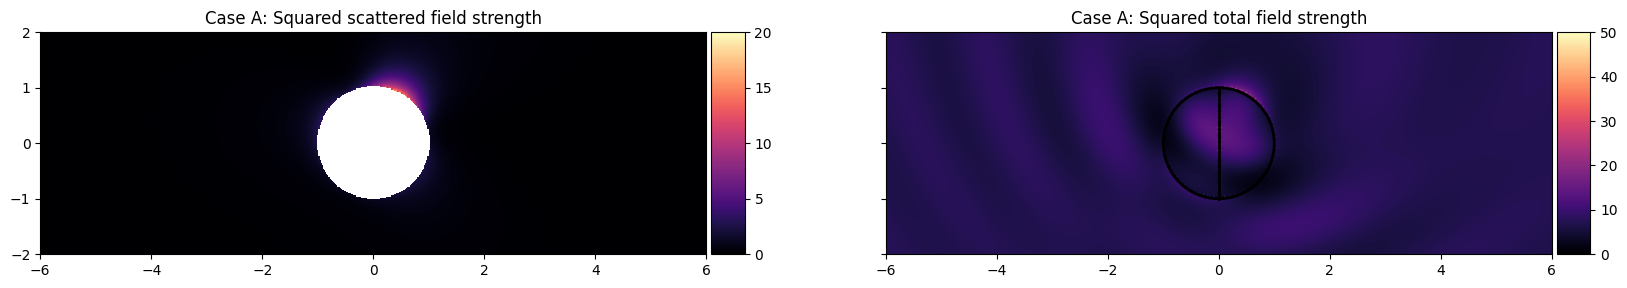

In [18]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

f0 = axes[0].imshow(scattered_image, origin='lower', cmap='magma',
                    extent=[-6, 6, -2, 2], vmin=0, vmax=5)
axes[0].set_title("Case " + case + ': Squared scattered field strength')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f0, cax=cax)

f1 = axes[1].imshow(total_image, origin='lower', cmap='magma',
                    extent=[-6, 6, -2, 2], vmin=0, vmax=5)

axes[1].set_title("Case " + case + ": Squared total field strength")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f1, cax=cax)

axes[1].add_patch(
    Circle((0, 0), 1, facecolor='None', edgecolor='k', lw=2)
)

axes[1].plot( (0,0), (-1,1), lw=2, color='k')

plt.savefig('results/' + case +'s1-squared-fields.pdf',bbox_inches = 'tight')
#plt.show()

In [17]:
scattered_image.mean()

nan